# Explore Repeat Hydrography Data from CCHDO

### In this example notebook we will explore data collected on a repeat hydrographic section part of the GO-SHIP repeat hydrographic program.

All hydrographic data part of this progam are publicly avaiable and are archived at [CCHDO](https://cchdo.ucsd.edu/). The section analyzed here (P18) is a meridonal transect in the eastern Pacific roughly along the 103$^o$W meridian. Section data is available at https://cchdo.ucsd.edu/cruise/33RO20161119. The netCDF file for the CTD data can be downloaded [here](https://cchdo.ucsd.edu/data/39492/33RO20161119_ctd.nc).

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gsw
%matplotlib inline

plt.rcParams["font.size"] = 16
plt.rcParams["figure.facecolor"] = 'white'
import warnings
warnings.filterwarnings('ignore')

In [2]:
# local path to data
datapath = './data/'

# Load netCDF file locally as xarray Dataset

ds = xr.load_dataset(datapath+'p18.nc')
ds

<xarray.Dataset>
Dimensions:                     (N_LEVELS: 5364, N_PROF: 213)
Coordinates:
    expocode                    (N_PROF) object '33RO20161119' ... '33RO20161...
    station                     (N_PROF) object '1' '2' '3' ... '211' '212'
    cast                        (N_PROF) int32 3 2 1 1 1 1 1 1 ... 2 1 1 1 1 1 1
    sample                      (N_PROF, N_LEVELS) object '3.0' '4.0' ... '' ''
    time                        (N_PROF) datetime64[ns] 2016-11-24T14:17:00 ....
    latitude                    (N_PROF) float64 22.69 22.87 ... -70.0 -68.07
    longitude                   (N_PROF) float64 -110.0 -110.0 ... -100.2 -95.0
    pressure                    (N_PROF, N_LEVELS) float64 3.0 4.0 ... nan nan
Dimensions without coordinates: N_LEVELS, N_PROF
Data variables: (12/16)
    section_id                  (N_PROF) object 'P18' 'P18' ... 'P18' 'P18'
    btm_depth                   (N_PROF) float64 2.625e+03 ... 4.435e+03
    pressure_qc                 (N_PROF, N_LEVELS) float32 2.0 2.0 ... nan nan
    ctd_temperature             (N_PROF, N_LEVELS) float64 27.92 27.92 ... nan
    ctd_temperature_qc          (N_PROF, N_LEVELS) float32 3.0 3.0 ... nan nan
    ctd_salinity                (N_PROF, N_LEVELS) float64 34.53 34.53 ... nan
    ...                          ...
    ctd_beamcp                  (N_PROF, N_LEVELS) float64 nan 0.0479 ... nan
    ctd_beamcp_qc               (N_PROF, N_LEVELS) float32 nan 2.0 ... nan nan
    ctd_beta700_raw             (N_PROF, N_LEVELS) float64 0.076 0.076 ... nan
    ctd_number_of_observations  (N_PROF, N_LEVELS) float64 19.0 36.0 ... nan nan
    profile_type                (N_PROF) object 'C' 'C' 'C' 'C' ... 'C' 'C' 'C'
    geometry_container          float64 nan
Attributes:
    Conventions:               CF-1.8 CCHDO-1.0
    cchdo_software_version:    hydro 1.0.2.3
    cchdo_parameters_version:  params 0.1.21
    comments:                  CTD,20200213CCHSIO\n Parameters removed from E...
    featureType:               profile

In [3]:
# list all variables in the dataset
all_vars = [i for i in ds.data_vars] 
all_vars

['section_id',
 'btm_depth',
 'pressure_qc',
 'ctd_temperature',
 'ctd_temperature_qc',
 'ctd_salinity',
 'ctd_salinity_qc',
 'ctd_oxygen',
 'ctd_oxygen_qc',
 'ctd_fluor_raw',
 'ctd_beamcp',
 'ctd_beamcp_qc',
 'ctd_beta700_raw',
 'ctd_number_of_observations',
 'profile_type',
 'geometry_container']

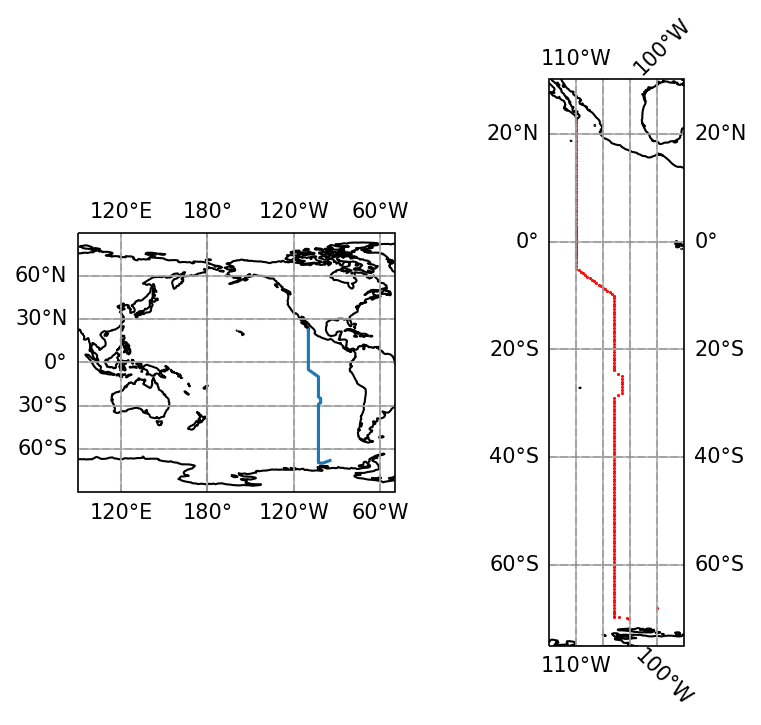

In [4]:
# Plot this hydrogrphic line on a MAP, and show station locations 

projection = ccrs.PlateCarree(central_longitude=180.0)

fig = plt.figure(figsize=(6,5),dpi=150)
ax1 = fig.add_subplot(121, projection=projection)
ax1.set_extent((90,310, -90, 90))
ax1.coastlines()
ax1.gridlines()
ax1.plot(ds.longitude,ds.latitude,transform = ccrs.PlateCarree())

gl1 = ax1.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.4, linestyle='--',)
# Adjust fontsize for tick labels
gl1.xlabel_style = {'size': 10}
gl1.ylabel_style = {'size': 10}

# add subplot for station locations
ax2 = fig.add_subplot(122, projection=projection)
ax2.set_extent((-115,-90, -75, 30))
ax2.coastlines()
ax2.gridlines()
ax2.scatter(ds.longitude,ds.latitude,transform = ccrs.PlateCarree(),
            marker='.',s=1,
            color='r')

gl2 = ax2.gridlines(
    draw_labels=True, linewidth=1, color='gray', alpha=0.4, linestyle='--',)
# Adjust fontsize for tick labels
gl2.xlabel_style = {'size': 10}
gl2.ylabel_style = {'size': 10}

plt.show()

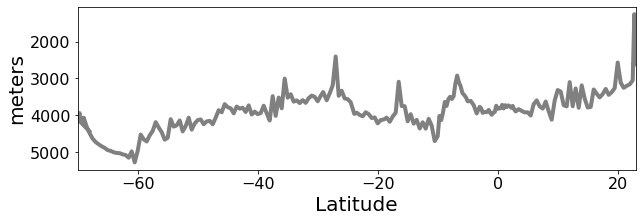

In [5]:
# Plot bottom bathymetry 
ds['btm_depth'].plot(figsize=(10,3),
                     yincrease=False,
                     x='latitude',
                     color='gray',
                     linewidth=4,
                     xlim=(-70,23),
                     )
plt.ylabel('meters',fontsize=20)
plt.xlabel('Latitude',fontsize=20)
plt.show()

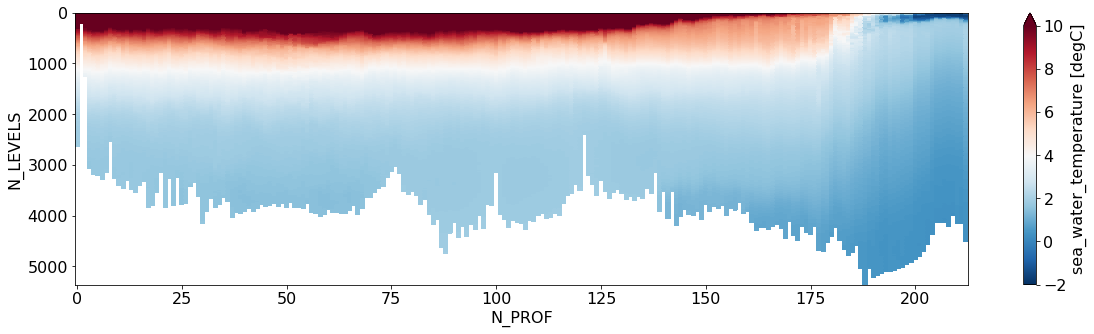

In [6]:
# Using xarray's plot wrapper, simple plot of Pressure Levels vs along-section Profile
ds.ctd_temperature.T.plot(figsize=(20,5),yincrease=False,cmap='RdBu_r',vmax=10,vmin=-2)
plt.show()

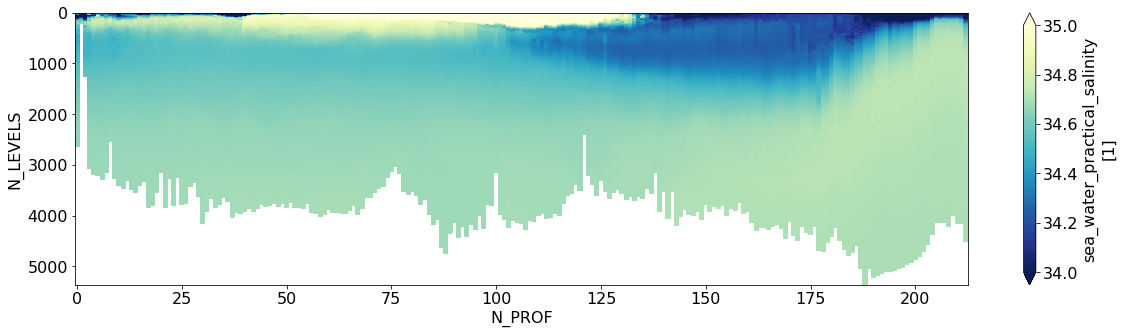

In [7]:
# Using xarray's plot wrapper, simple plot of Pressure Levels vs along-section Profile
ds.ctd_salinity.T.plot(figsize=(20,5),yincrease=False,cmap='YlGnBu_r',vmax=35.,vmin=34.)
plt.show()

#### Get some variables of interest in the dataset

In [8]:
exclude_vars = ['bottle_number']  # exclude these variables

# get a list of variables that we might be interested in-
# Filter remove one dimensional variables, QC flags and error variables

vars_of_interest = [i for i in all_vars if '_qc' not in i and '_error' not in i
                    and i not in exclude_vars 
                    and len(ds[i].dims)==2]
print(vars_of_interest)

['ctd_temperature', 'ctd_salinity', 'ctd_oxygen', 'ctd_fluor_raw', 'ctd_beamcp', 'ctd_beta700_raw', 'ctd_number_of_observations']


#### Next, we can calculate Absolute Salinity (SA) and Conservative Temperature ($\Theta$) and Potential Density ($\sigma_0$)using the GSW Toolbox

In [9]:
ds['SA'] = gsw.SA_from_SP(ds.ctd_salinity, ds.pressure, ds.longitude, ds.latitude)
ds['CT'] = gsw.CT_from_t(ds.SA,ds.ctd_temperature, ds.pressure)
ds['sigma_0'] = gsw.sigma0(ds.SA,ds.CT)

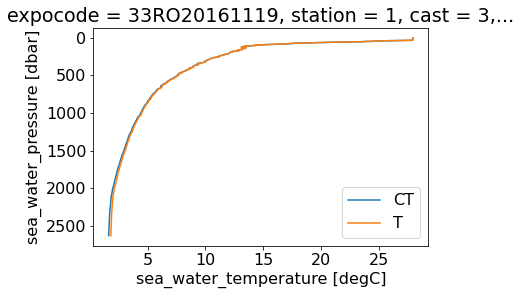

In [10]:
# Plot CTD Temperature and Conservative Temperature vs Pressure Level for the first profile (index 0)
ds.CT.T[:,0].plot(y='pressure',yincrease=False,label='CT')
ds.ctd_temperature.T[:,0].plot(y='pressure',yincrease=False,label='T')
plt.legend()
plt.show()

#### Now we can plot a T-S diagram using this information for all profiles along the section.
We will also contour potential density, which is useful to identify water masses and water-mass transformation

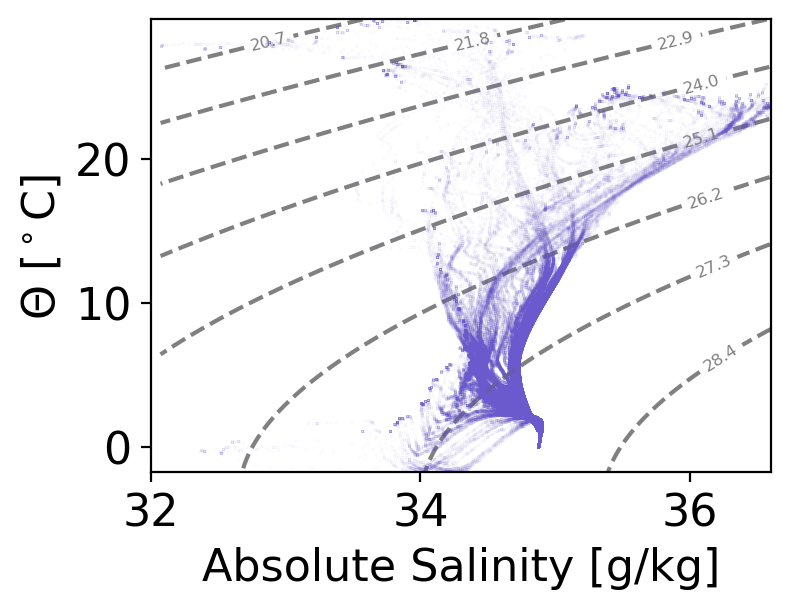

In [11]:
plt.figure(figsize=(4,3),dpi=200)

# Create a grid of SA and CT values using meshgrid
SA_vals = np.linspace(ds.SA.min(), ds.SA.max(), 100)
CT_vals = np.linspace(ds.CT.min(), ds.CT.max(), 100)
SA_grid, CT_grid = np.meshgrid(SA_vals, CT_vals)

# Calculate potential density at each point on the grid
p_density = gsw.sigma0(SA_grid, CT_grid)  # Assuming reference pressure of 0 dbar
# Scatter plot of Absolute Salinity vs. Conservative Temperature
plt.plot(ds.SA, ds.CT, 
         color='slateblue',
         marker='.',
         markersize=.1,
         alpha=0.2,
         linestyle='')

# Add potential density contours
density_levels = np.linspace(min(p_density.flatten()), max(p_density.flatten()), 10)  # Choose density levels
CS = plt.contour(SA_grid, CT_grid, p_density, 
                 levels=density_levels, 
                 colors='gray', 
                 linestyles='dashed')
plt.clabel(CS, inline=True, fontsize=6, fmt='%.1f')

# Label axes
plt.xlabel('Absolute Salinity [g/kg]')
plt.ylabel(r'$\Theta$ [$^\circ$C]')

# Set axis limit
plt.xlim(32,36.6)
plt.show()